In [8]:
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
import antropy as ant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from pycaret.classification import *
from scipy.stats import skew, kurtosis
import logging
import sys
mne.set_log_level(logging.WARNING)



In [2]:
def process_edf(subject):
    EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
    raw=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True, verbose=False)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw.set_annotations(annot_train, emit_warning=False)

    raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
    raw.drop_channels(['Marker'])

    raw.filter(0.3, 40, n_jobs=4)  # Filter the data with a 0.3-40 Hz bandpass
    annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4,
    }


    # keep last 30-min wake events before sleep and first 30-min wake events after
    # sleep and redefine annotations on raw data
    annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                    annot_train[-2]['onset'] + 30 * 60)
    raw_train = raw.copy()
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage W': 0,
                'Sleep stage 1': 1,
                'Sleep stage 2': 2,
                'Sleep stage 3/4': 3,
                'Sleep stage R': 4}

    # plot events
    # fig = mne.viz.plot_events(events_train, event_id=event_id,
    #                         sfreq=raw_train.info['sfreq'],
    #                         first_samp=events_train[0, 0])

    # keep the color-code for further plotting
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Create epochs from the event data with 30sec time window
    tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

    epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)
    psds, freqs = mne.time_frequency.psd_welch(epochs_train, fmin=0.5, fmax=40., verbose=False)



    n_epochs = len(epochs_train)
    n_channels = len(epochs_train.ch_names)
    epoch_length = tmax

    svd_entropies = np.zeros((n_epochs, n_channels))
    hfd = np.zeros((n_epochs, n_channels))
    perm_ent = np.zeros((n_epochs, n_channels))
    det_fluc = np.zeros((n_epochs, n_channels))


    for i, epoch in enumerate(epochs_train.get_data()):
        for j, channel_data in enumerate(epoch):
            svd_entropies[i, j] = ant.svd_entropy(channel_data, normalize=True)
            hfd[i, j] = ant.higuchi_fd(channel_data)
            perm_ent[i, j] = ant.perm_entropy(channel_data, order=3, normalize=True)
            det_fluc[i, j] = ant.detrended_fluctuation(channel_data)

    X_svd = svd_entropies
    X_hfd = hfd
    X_perm = perm_ent
    X_det = det_fluc
    Y = epochs_train.events[:, -1]
    X_PSD = psds

    data = epochs_train.get_data()

    mean = np.mean(data, axis=2)
    std_dev = np.std(data, axis=2)
    skewness = skew(data, axis=2)
    kurt = kurtosis(data, axis=2)

    X_time_domain = np.concatenate((mean, std_dev, skewness, kurt), axis=1)

    return X_svd, X_hfd, X_perm, X_det, X_PSD, X_time_domain, Y

In [3]:
X_all_svd, X_all_hfd, X_all_perm, X_all_det, X_all_PSD, X_all_time, Y_all = [], [], [], [], [], [], []
EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"

for subject in tqdm(os.listdir(EEG_path)):
    tqdm.write(subject, end='\r')
    X1, X2, X3, X4, X5, X6, Y = process_edf(subject)
    X_all_svd.append(X1)
    X_all_hfd.append(X2)
    X_all_perm.append(X3)
    X_all_det.append(X4)
    X_all_PSD.append(X5)
    X_all_time.append(X6)
    Y_all.append(Y)

  0%|          | 0/43 [00:00<?, ?it/s]

In [4]:
X_all_time_arr = np.vstack(X_all_time)
X_all_svd_arr = np.vstack(X_all_svd)
X_all_hfd_arr = np.vstack(X_all_hfd)

X_all_perm_arr = np.vstack(X_all_perm)
X_all_det_arr = np.vstack(X_all_det)
X_all_PSD_arr = np.vstack(X_all_PSD)
X_all_PSD_arr = X_all_PSD_arr.reshape(41490, -1)
Y_all_arr = np.concatenate(Y_all)

In [5]:
print(X_all_time_arr.shape, X_all_svd_arr.shape, X_all_hfd_arr.shape, X_all_perm_arr.shape, X_all_det_arr.shape, X_all_PSD_arr.shape, Y_all_arr.shape)

(41490, 16) (41490, 4) (41490, 4) (41490, 4) (41490, 4) (41490, 202) (41490,)


In [6]:
df_X_time = pd.DataFrame(X_all_time_arr)
df_X_svd = pd.DataFrame(X_all_svd_arr)
df_X_hfd = pd.DataFrame(X_all_hfd_arr)
df_X_perm = pd.DataFrame(X_all_perm_arr)
df_X_det = pd.DataFrame(X_all_det_arr)

df_X_PSD = pd.DataFrame(X_all_PSD_arr)
df_Y = pd.DataFrame(Y_all_arr)


df_X_svd.columns = ['EEG Fpz-Cz_svd', 'EEG Pz-Oz_svd', 'EOG horizontal_svd', 'EMG submental_svd']
df_X_hfd.columns = ['EEG Fpz-Cz_hfd', 'EEG Pz-Oz_hfd', 'EOG horizontal_hfd', 'EMG submental_hfd']
df_X_perm.columns = ['EEG Fpz-Cz_perm', 'EEG Pz-Oz_perm', 'EOG horizontal_perm', 'EMG submental_perm']
df_X_det.columns = ['EEG Fpz-Cz_det', 'EEG Pz-Oz_det', 'EOG horizontal_det', 'EMG submental_det']
df_X_time.columns = ['EEG Fpz-Cz_mean', 'EEG Pz-Oz_mean', 'EOG horizontal_mean', 'EMG submental_mean',\
                        'EEG Fpz-Cz_std', 'EEG Pz-Oz_std', 'EOG horizontal_std', 'EMG submental_std',\
                        'EEG Fpz-Cz_skew', 'EEG Pz-Oz_skew', 'EOG horizontal_skew', 'EMG submental_skew',\
                        'EEG Fpz-Cz_kurt', 'EEG Pz-Oz_kurt', 'EOG horizontal_kurt', 'EMG submental_kurt']
df_Y.columns = ['Sleep Stage']

In [7]:
df_input = pd.concat([df_X_svd, df_X_hfd, df_X_perm, df_X_det, df_X_PSD, df_X_time, df_Y ], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_input.drop('Sleep Stage', axis=1), df_input['Sleep Stage'], test_size=0.2, random_state=123, shuffle=True)
df_input_train = pd.concat([X_train, y_train], axis=1)
df_input_train['Sleep Stage'].value_counts()

2    15433
4     6551
3     5123
0     3308
1     2777
Name: Sleep Stage, dtype: int64

In [14]:
df_input_train = df_input_train.fillna(0)
df_input_train

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EMG submental_std,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Sleep Stage
12619,0.377578,0.458292,0.398813,0.895579,1.336917,1.355172,1.325159,1.932482,0.813686,0.834842,...,0.000002,-0.420627,-0.182158,0.062237,-0.653197,0.786134,0.022169,0.305462,1.212587,3
678,0.508783,0.510939,0.109054,0.711965,1.412006,1.400341,1.457457,1.920466,0.860368,0.838611,...,0.000001,1.411354,-0.576438,-0.039936,-0.075429,6.832584,2.888231,-0.850856,-0.262296,4
9218,0.584165,0.655964,0.234121,0.552357,1.419853,1.500688,1.545019,1.929650,0.905803,0.881021,...,0.000003,-0.657723,-0.208221,1.042037,0.324261,1.033820,0.229736,0.149532,-0.727463,4
18644,0.607997,0.673865,0.853197,0.918839,1.479321,1.492567,1.803744,1.951735,0.867738,0.855174,...,0.000004,0.072697,-0.120859,0.233535,-2.742661,0.647801,0.486154,0.407819,46.171369,2
9485,0.440909,0.506737,0.044253,0.511222,1.370464,1.427640,1.310166,1.910821,0.850145,0.867728,...,0.000004,1.166729,-0.693405,-0.935807,0.114589,8.482720,1.509006,-0.729615,-0.834354,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,0.457420,0.664714,0.148108,0.614515,1.413525,1.512943,1.288061,1.901611,0.911321,0.922995,...,0.000003,0.223077,0.077738,0.242487,-0.286109,0.329764,0.339178,0.807002,-0.371599,4
15377,0.494865,0.739695,0.138140,0.935914,1.656751,1.550094,1.335172,1.975148,0.953114,0.923534,...,0.000002,1.606370,-0.312652,-0.047149,-0.196321,5.481274,0.980916,-0.359324,2.350790,4
17730,0.683128,0.677743,0.917183,0.968867,1.586913,1.530839,1.921501,2.005492,0.902483,0.884500,...,0.000003,-0.395049,-0.043071,0.007932,-0.060129,1.270258,0.529275,0.547754,0.352971,2
28030,0.735275,0.718844,0.123601,0.497601,1.646787,1.633783,1.666865,1.923361,0.925595,0.898975,...,0.000004,0.106046,0.442080,0.691064,0.662618,0.355100,0.987348,-0.727085,0.366113,1


In [15]:
clf = setup(
    data = df_input_train,
    target = 'Sleep Stage',
    normalize = True,
    fix_imbalance=True
    )

,Description,Value
0,session_id,7003
1,Target,Sleep Stage
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(33192, 235)"
5,Missing Values,False
6,Numeric Features,234
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [34]:
compare_models(fold=15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8744,0.9793,0.8547,0.8777,0.8755,0.8234,0.8238,177.7513
lightgbm,Light Gradient Boosting Machine,0.8714,0.9791,0.8561,0.8764,0.8730,0.8198,0.8204,12.3633
rf,Random Forest Classifier,0.8614,0.9743,0.8396,0.8661,0.8630,0.8051,0.8055,15.4633
et,Extra Trees Classifier,0.8600,0.9732,0.8329,0.8612,0.8601,0.8021,0.8023,9.6213
gbc,Gradient Boosting Classifier,0.8417,0.9717,0.8405,0.8553,0.8454,0.7810,0.7833,223.0213
svm,SVM - Linear Kernel,0.7922,0.0000,0.7954,0.8166,0.7979,0.7159,0.7207,5.8793
knn,K Neighbors Classifier,0.7860,0.9295,0.7940,0.8227,0.7940,0.7109,0.7187,18.8880
lda,Linear Discriminant Analysis,0.7688,0.9387,0.7622,0.7957,0.7771,0.6826,0.6863,6.2940
dt,Decision Tree Classifier,0.7642,0.8410,0.7402,0.7770,0.7688,0.6722,0.6736,8.5440
ridge,Ridge Classifier,0.7401,0.0000,0.7493,0.7739,0.7459,0.6492,0.6572,5.0680


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=7075, reg_alpha=0, ...)

In [16]:
xgb_1 = create_model('xgboost', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8651,0.9781,0.8471,0.8693,0.8666,0.8103,0.8107
1,0.8754,0.9776,0.8542,0.8788,0.8766,0.8250,0.8255
2,0.8948,0.9838,0.8695,0.8972,0.8957,0.8516,0.8518
3,0.8586,0.9751,0.8292,0.8606,0.8594,0.8006,0.8007
4,0.8909,0.9818,0.8801,0.8942,0.8921,0.8459,0.8461
5,0.8670,0.9758,0.8408,0.8683,0.8675,0.8120,0.8121
6,0.8612,0.9765,0.8425,0.8617,0.8611,0.8044,0.8047
7,0.8825,0.9796,0.8576,0.8847,0.8833,0.8343,0.8346
8,0.8631,0.9769,0.8400,0.8657,0.8637,0.8079,0.8086


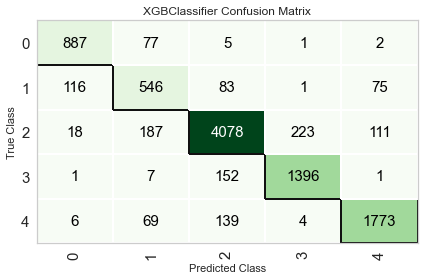

In [18]:
plot_model(xgb_1, plot = 'confusion_matrix')

In [19]:
predictions = predict_model(xgb_1, data=X_test)

In [20]:
predictions

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Label,Score
18567,0.522136,0.555490,0.748603,0.629966,1.379251,1.412683,1.647078,1.899378,0.817266,0.828515,...,-0.389810,-0.126041,0.277877,-0.520437,0.631381,0.460520,0.371023,-0.027936,3,0.9632
19479,0.687469,0.704091,0.148299,0.701872,1.555299,1.557796,1.533088,2.011091,0.926247,0.910469,...,0.153854,-0.219804,0.755771,-0.014284,1.284759,1.337007,0.317921,-0.142993,1,0.9620
13747,0.628773,0.723419,0.151898,0.711818,1.593170,1.563852,1.438214,1.956108,0.930798,0.933330,...,-0.126422,-0.356987,0.437253,-0.041045,0.126070,0.834838,0.044838,-0.244604,4,0.9952
29625,0.607749,0.637054,0.624866,0.653667,1.461953,1.515899,1.581997,1.913407,0.883679,0.900937,...,0.307589,-0.120329,0.565389,-0.327653,0.960171,0.549358,0.735457,0.188843,2,0.9989
10651,0.497123,0.507046,0.539025,0.364005,1.486402,1.477578,1.577149,1.546574,0.881483,0.871074,...,1.280386,-0.270902,-0.124251,-0.437685,3.919170,3.029200,-0.023671,-1.177968,2,0.9391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25274,0.443077,0.444879,0.180270,0.492666,1.373709,1.365362,1.383294,1.954051,0.806453,0.824010,...,-0.475137,-0.358130,0.467285,-0.885676,0.706803,0.801726,-0.478614,1.357755,3,0.9992
2030,0.523434,0.837868,0.423255,0.952573,1.678808,1.825048,1.709062,2.028145,0.968637,0.952494,...,1.399590,-0.095574,-0.848940,0.129568,4.928953,0.283397,3.930070,-0.338373,0,0.9986
18532,0.614656,0.624886,0.713591,0.725425,1.455713,1.457120,1.638692,1.889728,0.852662,0.862434,...,-0.091391,-0.119084,0.120504,0.267245,0.182867,0.463823,0.164600,-0.343341,2,0.9585
3197,0.326508,0.338753,0.323336,0.791442,1.194303,1.229151,1.273737,1.930606,0.768572,0.801872,...,-0.228971,-0.136023,0.497156,0.186423,0.063182,0.257340,0.390595,-0.589227,3,0.9999


In [21]:
preds = predictions['Label'].astype(float)
accuracy_score(y_test, preds)

0.8714147987466859

In [22]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[ 757   72    1    1    9]
 [  72  475   79    1   58]
 [  16  160 3385  192  130]
 [   1    7  101 1182    1]
 [   3   64   97    2 1432]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       840
           1       0.61      0.69      0.65       685
           2       0.92      0.87      0.90      3883
           3       0.86      0.91      0.89      1292
           4       0.88      0.90      0.89      1598

    accuracy                           0.87      8298
   macro avg       0.83      0.86      0.84      8298
weighted avg       0.88      0.87      0.87      8298



In [23]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

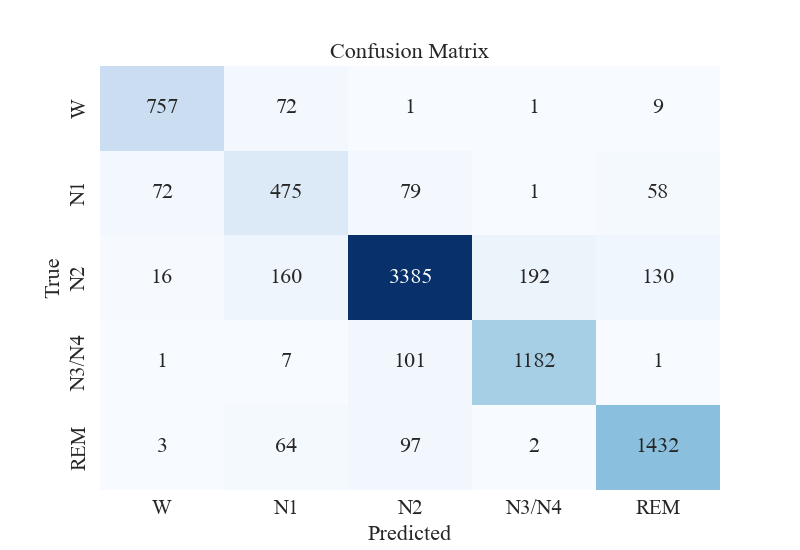

In [39]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16
labels = ['W', 'N1', 'N2', 'N3/N4', 'REM']
cm = [[ 757,   72,    1,   1,    9],
 [  72,  475,   79,    1,   58],
 [  16,  160, 3385,  192,  130],
 [   1,    7,  101, 1182,    1],
 [   3,   64,   97,    2, 1432]]

plt.figsize=(8,8)
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [17]:
et_1 = create_model('et', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8554,0.9709,0.8352,0.8597,0.8566,0.7955,0.7959
1,0.8567,0.9739,0.8413,0.8618,0.8585,0.7989,0.7994
2,0.8638,0.9771,0.8268,0.8644,0.8637,0.8067,0.8069
3,0.8560,0.9712,0.8225,0.8566,0.8557,0.7965,0.7968
4,0.8606,0.9741,0.8437,0.8627,0.8611,0.8031,0.8033
5,0.8547,0.9705,0.8175,0.8526,0.8530,0.7937,0.7939
6,0.8496,0.9701,0.8280,0.8502,0.8494,0.7872,0.7874
7,0.8509,0.9716,0.8160,0.8522,0.8514,0.7893,0.7894
8,0.8618,0.9716,0.8398,0.8630,0.8617,0.8047,0.8050


In [ ]:
lgbm_1 = create_model('lightgbm', fold=15)

In [ ]:
rf_1 = create_model('rf', fold=15)

## 4 Stages - Wake, Light, Deep and REM

In [40]:
def process_edf(subject):
    EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
    raw=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True, verbose=False)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw.set_annotations(annot_train, emit_warning=False)

    raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
    raw.drop_channels(['Marker'])

    raw.filter(0.3, 40, n_jobs=4)  # Filter the data with a 0.3-40 Hz bandpass
    annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 1,
    'Sleep stage 3': 2,
    'Sleep stage 4': 2,
    'Sleep stage R': 3,
    }


    # keep last 30-min wake events before sleep and first 30-min wake events after
    # sleep and redefine annotations on raw data
    annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                    annot_train[-2]['onset'] + 30 * 60)
    raw_train = raw.copy()
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage W': 0,
                'Sleep stage 1/2': 1,
                'Sleep stage 3/4': 2,
                'Sleep stage R': 3}

    # plot events
    # fig = mne.viz.plot_events(events_train, event_id=event_id,
    #                         sfreq=raw_train.info['sfreq'],
    #                         first_samp=events_train[0, 0])

    # keep the color-code for further plotting
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Create epochs from the event data with 30sec time window
    tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

    epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)
    psds, freqs = mne.time_frequency.psd_welch(epochs_train, fmin=0.5, fmax=40., verbose=False)



    n_epochs = len(epochs_train)
    n_channels = len(epochs_train.ch_names)
    epoch_length = tmax

    svd_entropies = np.zeros((n_epochs, n_channels))
    hfd = np.zeros((n_epochs, n_channels))
    perm_ent = np.zeros((n_epochs, n_channels))
    det_fluc = np.zeros((n_epochs, n_channels))


    for i, epoch in enumerate(epochs_train.get_data()):
        for j, channel_data in enumerate(epoch):
            svd_entropies[i, j] = ant.svd_entropy(channel_data, normalize=True)
            hfd[i, j] = ant.higuchi_fd(channel_data)
            perm_ent[i, j] = ant.perm_entropy(channel_data, order=3, normalize=True)
            det_fluc[i, j] = ant.detrended_fluctuation(channel_data)

    X_svd = svd_entropies
    X_hfd = hfd
    X_perm = perm_ent
    X_det = det_fluc
    Y = epochs_train.events[:, -1]
    X_PSD = psds

    data = epochs_train.get_data()

    mean = np.mean(data, axis=2)
    std_dev = np.std(data, axis=2)
    skewness = skew(data, axis=2)
    kurt = kurtosis(data, axis=2)

    X_time_domain = np.concatenate((mean, std_dev, skewness, kurt), axis=1)

    return X_svd, X_hfd, X_perm, X_det, X_PSD, X_time_domain, Y

In [41]:
X_all_svd, X_all_hfd, X_all_perm, X_all_det, X_all_PSD, X_all_time, Y_all = [], [], [], [], [], [], []
EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"

for subject in tqdm(os.listdir(EEG_path)):
    tqdm.write(subject, end='\r')
    X1, X2, X3, X4, X5, X6, Y = process_edf(subject)
    X_all_svd.append(X1)
    X_all_hfd.append(X2)
    X_all_perm.append(X3)
    X_all_det.append(X4)
    X_all_PSD.append(X5)
    X_all_time.append(X6)
    Y_all.append(Y)

  0%|          | 0/43 [00:00<?, ?it/s]

In [42]:
X_all_time_arr = np.vstack(X_all_time)
X_all_svd_arr = np.vstack(X_all_svd)
X_all_hfd_arr = np.vstack(X_all_hfd)

X_all_perm_arr = np.vstack(X_all_perm)
X_all_det_arr = np.vstack(X_all_det)
X_all_PSD_arr = np.vstack(X_all_PSD)
X_all_PSD_arr = X_all_PSD_arr.reshape(41490, -1)
Y_all_arr = np.concatenate(Y_all)

In [43]:
print(X_all_time_arr.shape, X_all_svd_arr.shape, X_all_hfd_arr.shape, X_all_perm_arr.shape, X_all_det_arr.shape, X_all_PSD_arr.shape, Y_all_arr.shape)

(41490, 16) (41490, 4) (41490, 4) (41490, 4) (41490, 4) (41490, 202) (41490,)


In [44]:
df_X_time = pd.DataFrame(X_all_time_arr)
df_X_svd = pd.DataFrame(X_all_svd_arr)
df_X_hfd = pd.DataFrame(X_all_hfd_arr)
df_X_perm = pd.DataFrame(X_all_perm_arr)
df_X_det = pd.DataFrame(X_all_det_arr)

df_X_PSD = pd.DataFrame(X_all_PSD_arr)
df_Y = pd.DataFrame(Y_all_arr)


df_X_svd.columns = ['EEG Fpz-Cz_svd', 'EEG Pz-Oz_svd', 'EOG horizontal_svd', 'EMG submental_svd']
df_X_hfd.columns = ['EEG Fpz-Cz_hfd', 'EEG Pz-Oz_hfd', 'EOG horizontal_hfd', 'EMG submental_hfd']
df_X_perm.columns = ['EEG Fpz-Cz_perm', 'EEG Pz-Oz_perm', 'EOG horizontal_perm', 'EMG submental_perm']
df_X_det.columns = ['EEG Fpz-Cz_det', 'EEG Pz-Oz_det', 'EOG horizontal_det', 'EMG submental_det']
df_X_time.columns = ['EEG Fpz-Cz_mean', 'EEG Pz-Oz_mean', 'EOG horizontal_mean', 'EMG submental_mean',\
                        'EEG Fpz-Cz_std', 'EEG Pz-Oz_std', 'EOG horizontal_std', 'EMG submental_std',\
                        'EEG Fpz-Cz_skew', 'EEG Pz-Oz_skew', 'EOG horizontal_skew', 'EMG submental_skew',\
                        'EEG Fpz-Cz_kurt', 'EEG Pz-Oz_kurt', 'EOG horizontal_kurt', 'EMG submental_kurt']
df_Y.columns = ['Sleep Stage']

In [45]:
df_input = pd.concat([df_X_svd, df_X_hfd, df_X_perm, df_X_det, df_X_PSD, df_X_time, df_Y ], axis=1)

In [46]:
df_input

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EMG submental_std,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Sleep Stage
0,0.987039,0.981167,0.793655,0.999226,1.729953,1.892506,1.756279,1.954969,0.946917,0.955711,...,0.000124,-3.075678,1.332415,-0.821078,-6.740439,291.523782,201.569396,13.635766,338.614692,0
1,0.525045,0.530804,0.367215,0.998277,1.527066,1.838841,1.621904,2.022486,0.971058,0.983652,...,0.000020,1.477339,1.045068,0.098621,-0.657815,3.276232,4.301412,-0.663105,7.638272,0
2,0.575597,0.671199,0.439653,0.987337,1.478273,1.847214,1.835012,2.008475,0.966203,0.989973,...,0.000023,2.178262,-0.424238,0.756337,-0.020747,7.854767,4.168572,0.916823,5.337252,0
3,0.526120,0.614145,0.596802,0.999513,1.576452,1.838328,1.883132,2.011644,0.978298,0.987571,...,0.000019,0.972742,1.240378,-0.476201,-0.250570,3.591780,5.138569,-0.413813,7.690777,0
4,0.376618,0.498464,0.423870,0.908455,1.520067,1.809161,1.756443,2.015401,0.985030,0.960600,...,0.000014,1.527443,0.353598,-0.498222,0.246536,1.632868,6.017006,-0.108143,2.962941,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41485,0.460974,0.942977,0.348455,0.388256,1.422695,1.915871,1.389126,1.768020,0.968626,0.993327,...,0.000133,2.613621,0.080913,0.370055,-1.499241,10.960019,0.914838,0.754730,3.175698,0
41486,0.513377,0.888967,0.426211,0.522939,1.453040,1.914228,1.500767,1.903348,0.975148,0.993540,...,0.000127,2.208662,-0.739897,0.030930,-1.540903,6.717767,3.091480,1.020134,5.578316,0
41487,0.517469,0.919033,0.337180,0.633221,1.406252,1.899414,1.299624,1.946126,0.956023,0.993835,...,0.000088,1.669194,0.000556,-0.080864,0.133517,5.362088,0.955720,2.094039,0.173725,0
41488,0.529215,0.796246,0.455389,0.897802,1.514632,1.884125,1.552587,1.969740,0.978405,0.995693,...,0.000090,2.045903,1.460704,1.300098,0.463508,6.598154,5.314809,4.117882,3.020165,0


In [47]:
df_input = df_input.fillna(0)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_input.drop('Sleep Stage', axis=1), df_input['Sleep Stage'], test_size=0.2, random_state=123, shuffle=True)
df_input_train = pd.concat([X_train, y_train], axis=1)
df_input_train['Sleep Stage'].value_counts()

1    18210
3     6551
2     5123
0     3308
Name: Sleep Stage, dtype: int64

In [49]:
df_input_train = df_input_train.fillna(0)
df_input_train

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EMG submental_std,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Sleep Stage
12619,0.377578,0.458292,0.398813,0.895579,1.336917,1.355172,1.325159,1.932482,0.813686,0.834842,...,0.000002,-0.420627,-0.182158,0.062237,-0.653197,0.786134,0.022169,0.305462,1.212587,2
678,0.508783,0.510939,0.109054,0.711965,1.412006,1.400341,1.457457,1.920466,0.860368,0.838611,...,0.000001,1.411354,-0.576438,-0.039936,-0.075429,6.832584,2.888231,-0.850856,-0.262296,3
9218,0.584165,0.655964,0.234121,0.552357,1.419853,1.500688,1.545019,1.929650,0.905803,0.881021,...,0.000003,-0.657723,-0.208221,1.042037,0.324261,1.033820,0.229736,0.149532,-0.727463,3
18644,0.607997,0.673865,0.853197,0.918839,1.479321,1.492567,1.803744,1.951735,0.867738,0.855174,...,0.000004,0.072697,-0.120859,0.233535,-2.742661,0.647801,0.486154,0.407819,46.171369,1
9485,0.440909,0.506737,0.044253,0.511222,1.370464,1.427640,1.310166,1.910821,0.850145,0.867728,...,0.000004,1.166729,-0.693405,-0.935807,0.114589,8.482720,1.509006,-0.729615,-0.834354,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,0.457420,0.664714,0.148108,0.614515,1.413525,1.512943,1.288061,1.901611,0.911321,0.922995,...,0.000003,0.223077,0.077738,0.242487,-0.286109,0.329764,0.339178,0.807002,-0.371599,3
15377,0.494865,0.739695,0.138140,0.935914,1.656751,1.550094,1.335172,1.975148,0.953114,0.923534,...,0.000002,1.606370,-0.312652,-0.047149,-0.196321,5.481274,0.980916,-0.359324,2.350790,3
17730,0.683128,0.677743,0.917183,0.968867,1.586913,1.530839,1.921501,2.005492,0.902483,0.884500,...,0.000003,-0.395049,-0.043071,0.007932,-0.060129,1.270258,0.529275,0.547754,0.352971,1
28030,0.735275,0.718844,0.123601,0.497601,1.646787,1.633783,1.666865,1.923361,0.925595,0.898975,...,0.000004,0.106046,0.442080,0.691064,0.662618,0.355100,0.987348,-0.727085,0.366113,1


In [50]:
clf = setup(
    data = df_input_train,
    target = 'Sleep Stage',
    normalize = True,
    fix_imbalance=True
    )

,Description,Value
0,session_id,6243
1,Target,Sleep Stage
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(33192, 235)"
5,Missing Values,False
6,Numeric Features,234
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models(fold=15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8744,0.9793,0.8547,0.8777,0.8755,0.8234,0.8238,177.7513
lightgbm,Light Gradient Boosting Machine,0.8714,0.9791,0.8561,0.8764,0.8730,0.8198,0.8204,12.3633
rf,Random Forest Classifier,0.8614,0.9743,0.8396,0.8661,0.8630,0.8051,0.8055,15.4633
et,Extra Trees Classifier,0.8600,0.9732,0.8329,0.8612,0.8601,0.8021,0.8023,9.6213
gbc,Gradient Boosting Classifier,0.8417,0.9717,0.8405,0.8553,0.8454,0.7810,0.7833,223.0213
svm,SVM - Linear Kernel,0.7922,0.0000,0.7954,0.8166,0.7979,0.7159,0.7207,5.8793
knn,K Neighbors Classifier,0.7860,0.9295,0.7940,0.8227,0.7940,0.7109,0.7187,18.8880
lda,Linear Discriminant Analysis,0.7688,0.9387,0.7622,0.7957,0.7771,0.6826,0.6863,6.2940
dt,Decision Tree Classifier,0.7642,0.8410,0.7402,0.7770,0.7688,0.6722,0.6736,8.5440
ridge,Ridge Classifier,0.7401,0.0000,0.7493,0.7739,0.7459,0.6492,0.6572,5.0680


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=7075, reg_alpha=0, ...)

In [51]:
xgb_2 = create_model('xgboost', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8941,0.9762,0.9016,0.8955,0.8943,0.8336,0.8341
1,0.8974,0.9778,0.9132,0.9004,0.8977,0.8399,0.8411
2,0.8909,0.9727,0.8982,0.8930,0.8912,0.8291,0.8298
3,0.8999,0.9792,0.9151,0.9032,0.9004,0.8439,0.8450
4,0.8986,0.9765,0.9095,0.9005,0.8989,0.8411,0.8417
5,0.9090,0.9827,0.9210,0.9112,0.9093,0.8577,0.8586
6,0.9051,0.9820,0.9211,0.9083,0.9055,0.8522,0.8535
7,0.8935,0.9776,0.9032,0.8963,0.8939,0.8338,0.8349
8,0.9064,0.9820,0.9185,0.9088,0.9067,0.8537,0.8546


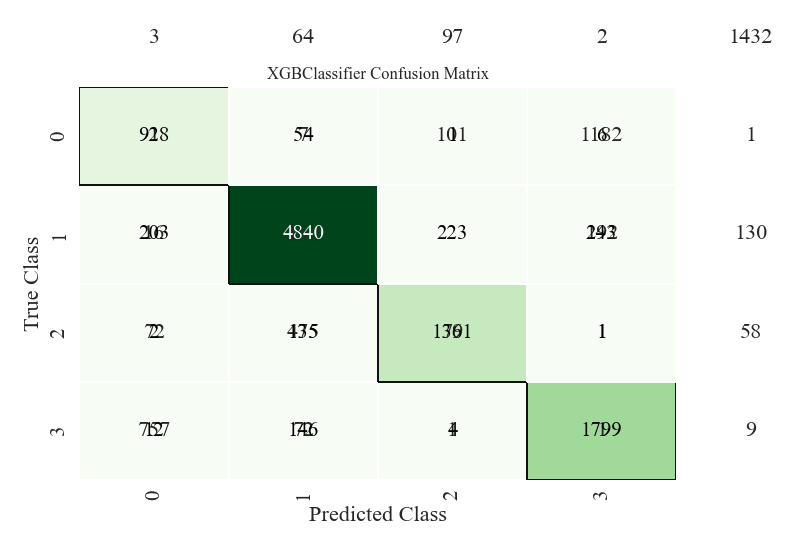

In [58]:
plot_model(xgb_2, plot = 'confusion_matrix')

In [59]:
predictions = predict_model(xgb_2, data=X_test)

In [60]:
predictions

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Label,Score
18567,0.522136,0.555490,0.748603,0.629966,1.379251,1.412683,1.647078,1.899378,0.817266,0.828515,...,-0.389810,-0.126041,0.277877,-0.520437,0.631381,0.460520,0.371023,-0.027936,2,0.9568
19479,0.687469,0.704091,0.148299,0.701872,1.555299,1.557796,1.533088,2.011091,0.926247,0.910469,...,0.153854,-0.219804,0.755771,-0.014284,1.284759,1.337007,0.317921,-0.142993,1,0.9869
13747,0.628773,0.723419,0.151898,0.711818,1.593170,1.563852,1.438214,1.956108,0.930798,0.933330,...,-0.126422,-0.356987,0.437253,-0.041045,0.126070,0.834838,0.044838,-0.244604,3,0.9896
29625,0.607749,0.637054,0.624866,0.653667,1.461953,1.515899,1.581997,1.913407,0.883679,0.900937,...,0.307589,-0.120329,0.565389,-0.327653,0.960171,0.549358,0.735457,0.188843,1,0.9987
10651,0.497123,0.507046,0.539025,0.364005,1.486402,1.477578,1.577149,1.546574,0.881483,0.871074,...,1.280386,-0.270902,-0.124251,-0.437685,3.919170,3.029200,-0.023671,-1.177968,1,0.9780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25274,0.443077,0.444879,0.180270,0.492666,1.373709,1.365362,1.383294,1.954051,0.806453,0.824010,...,-0.475137,-0.358130,0.467285,-0.885676,0.706803,0.801726,-0.478614,1.357755,2,0.9998
2030,0.523434,0.837868,0.423255,0.952573,1.678808,1.825048,1.709062,2.028145,0.968637,0.952494,...,1.399590,-0.095574,-0.848940,0.129568,4.928953,0.283397,3.930070,-0.338373,0,0.9996
18532,0.614656,0.624886,0.713591,0.725425,1.455713,1.457120,1.638692,1.889728,0.852662,0.862434,...,-0.091391,-0.119084,0.120504,0.267245,0.182867,0.463823,0.164600,-0.343341,1,0.9771
3197,0.326508,0.338753,0.323336,0.791442,1.194303,1.229151,1.273737,1.930606,0.768572,0.801872,...,-0.228971,-0.136023,0.497156,0.186423,0.063182,0.257340,0.390595,-0.589227,2,1.0000


In [61]:
preds = predictions['Label'].astype(float)
accuracy_score(y_test, preds)

0.8919016630513377

In [62]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[ 784   44    0   12]
 [ 154 3988  207  219]
 [   1  108 1183    0]
 [   6  144    2 1446]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       840
           1       0.93      0.87      0.90      4568
           2       0.85      0.92      0.88      1292
           3       0.86      0.90      0.88      1598

    accuracy                           0.89      8298
   macro avg       0.87      0.91      0.89      8298
weighted avg       0.89      0.89      0.89      8298



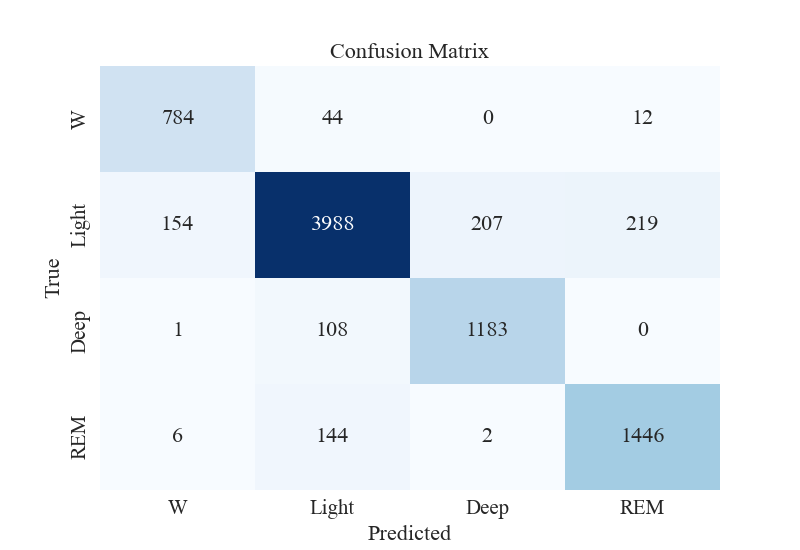

In [64]:
%matplotlib widget
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16
labels = ['W', 'Light', 'Deep', 'REM']
cm = [[ 784,   44,    0,   12],
 [ 154, 3988,  207,  219],
 [   1,  108, 1183,    0],
 [   6,  144,    2, 1446]]

plt.figsize=(8,8)
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [45]:
et_2 = create_model('et', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8761,0.9676,0.8951,0.8816,0.8768,0.8073,0.8088
1,0.8673,0.9683,0.8772,0.8719,0.8680,0.7924,0.7934
2,0.8765,0.9668,0.8930,0.8799,0.8769,0.8074,0.8085
3,0.8755,0.9704,0.8975,0.8815,0.8760,0.8067,0.8084
4,0.8802,0.9661,0.8905,0.8826,0.8805,0.8122,0.8129
5,0.8786,0.9715,0.8880,0.8810,0.8790,0.8097,0.8104
6,0.8771,0.9712,0.8889,0.8804,0.8774,0.8072,0.8080
7,0.8683,0.9664,0.8800,0.8734,0.8691,0.7942,0.7953
8,0.8771,0.9692,0.8991,0.8842,0.8782,0.8095,0.8115


In [46]:
lgbm = create_model('lightgbm', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8957,0.9761,0.9124,0.8984,0.8960,0.8374,0.8385
1,0.8890,0.9781,0.8995,0.8919,0.8895,0.8267,0.8277
2,0.9039,0.9789,0.9095,0.9052,0.9042,0.8488,0.8492
3,0.8998,0.9792,0.9227,0.9044,0.9002,0.8447,0.8465
4,0.8827,0.9735,0.9035,0.8867,0.8831,0.8182,0.8199
5,0.9029,0.9777,0.9096,0.9040,0.9031,0.8472,0.8476
6,0.9070,0.9801,0.9217,0.9097,0.9073,0.8549,0.8560
7,0.8982,0.9757,0.9126,0.9010,0.8986,0.8410,0.8419
8,0.8977,0.9755,0.9172,0.9018,0.8981,0.8412,0.8429


In [47]:
rf = create_model('rf', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8745,0.9683,0.8959,0.8807,0.8753,0.8055,0.8074
1,0.8807,0.9714,0.8915,0.8848,0.8814,0.8135,0.8145
2,0.8941,0.9715,0.9071,0.8973,0.8945,0.8342,0.8350
3,0.8822,0.9737,0.9019,0.8880,0.8830,0.8171,0.8188
4,0.8833,0.9680,0.8993,0.8866,0.8837,0.8179,0.8190
5,0.8931,0.9734,0.8984,0.8946,0.8933,0.8315,0.8318
6,0.8915,0.9732,0.9036,0.8944,0.8919,0.8299,0.8307
7,0.8765,0.9681,0.8889,0.8815,0.8775,0.8074,0.8086
8,0.8843,0.9703,0.9041,0.8908,0.8853,0.8206,0.8225


## 3 Stages - W, NREM and REM

In [65]:
def process_edf(subject):
    EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"
    raw=None
    annot_train=None
    files = os.listdir(EEG_path+subject)
    for file in os.listdir(EEG_path+subject):
        if (file.split('-')[1].split('.')[0] == 'PSG'):
            raw = mne.io.read_raw_edf(EEG_path+subject+'/'+file, stim_channel='Marker', preload=True, verbose=False)
        else:
            annot_train = mne.read_annotations(EEG_path+subject+'/'+file)
            raw.set_annotations(annot_train, emit_warning=False)

    raw.set_channel_types({'EOG horizontal': 'eog', 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg', 'EMG submental': 'misc'})
    raw.drop_channels(['Marker'])

    raw.filter(0.3, 40, n_jobs=4)  # Filter the data with a 0.3-40 Hz bandpass
    annot_events = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 1,
    'Sleep stage 3': 1,
    'Sleep stage 4': 1,
    'Sleep stage R': 2,
    }


    # keep last 30-min wake events before sleep and first 30-min wake events after
    # sleep and redefine annotations on raw data
    annot_train.crop(annot_train[0]['onset'] - 30 * 60,
                    annot_train[-2]['onset'] + 30 * 60)
    raw_train = raw.copy()
    raw_train.set_annotations(annot_train, emit_warning=False)
    events_train, _ = mne.events_from_annotations(raw_train, event_id = annot_events, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage W': 0,
                'Sleep stage 1/2/3/4': 1,
                'Sleep stage R': 2}

    # plot events
    # fig = mne.viz.plot_events(events_train, event_id=event_id,
    #                         sfreq=raw_train.info['sfreq'],
    #                         first_samp=events_train[0, 0])

    # keep the color-code for further plotting
    stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Create epochs from the event data with 30sec time window
    tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

    epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, preload=True)
    psds, freqs = mne.time_frequency.psd_welch(epochs_train, fmin=0.5, fmax=40., verbose=False)



    n_epochs = len(epochs_train)
    n_channels = len(epochs_train.ch_names)
    epoch_length = tmax

    svd_entropies = np.zeros((n_epochs, n_channels))
    hfd = np.zeros((n_epochs, n_channels))
    perm_ent = np.zeros((n_epochs, n_channels))
    det_fluc = np.zeros((n_epochs, n_channels))


    for i, epoch in enumerate(epochs_train.get_data()):
        for j, channel_data in enumerate(epoch):
            svd_entropies[i, j] = ant.svd_entropy(channel_data, normalize=True)
            hfd[i, j] = ant.higuchi_fd(channel_data)
            perm_ent[i, j] = ant.perm_entropy(channel_data, order=3, normalize=True)
            det_fluc[i, j] = ant.detrended_fluctuation(channel_data)

    X_svd = svd_entropies
    X_hfd = hfd
    X_perm = perm_ent
    X_det = det_fluc
    Y = epochs_train.events[:, -1]
    X_PSD = psds

    data = epochs_train.get_data()

    mean = np.mean(data, axis=2)
    std_dev = np.std(data, axis=2)
    skewness = skew(data, axis=2)
    kurt = kurtosis(data, axis=2)

    X_time_domain = np.concatenate((mean, std_dev, skewness, kurt), axis=1)

    return X_svd, X_hfd, X_perm, X_det, X_PSD, X_time_domain, Y

In [66]:
X_all_svd, X_all_hfd, X_all_perm, X_all_det, X_all_PSD, X_all_time, Y_all = [], [], [], [], [], [], []
EEG_path = "C:/Users/utkar/Desktop/Research_Paper/EEG Analysis/Sleep_Stage_Detection/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-telemetry/"

for subject in tqdm(os.listdir(EEG_path)):
    tqdm.write(subject, end='\r')
    X1, X2, X3, X4, X5, X6, Y = process_edf(subject)
    X_all_svd.append(X1)
    X_all_hfd.append(X2)
    X_all_perm.append(X3)
    X_all_det.append(X4)
    X_all_PSD.append(X5)
    X_all_time.append(X6)
    Y_all.append(Y)

  0%|          | 0/43 [00:00<?, ?it/s]

In [67]:
X_all_time_arr = np.vstack(X_all_time)
X_all_svd_arr = np.vstack(X_all_svd)
X_all_hfd_arr = np.vstack(X_all_hfd)

X_all_perm_arr = np.vstack(X_all_perm)
X_all_det_arr = np.vstack(X_all_det)
X_all_PSD_arr = np.vstack(X_all_PSD)
X_all_PSD_arr = X_all_PSD_arr.reshape(41490, -1)
Y_all_arr = np.concatenate(Y_all)

In [68]:
print(X_all_time_arr.shape, X_all_svd_arr.shape, X_all_hfd_arr.shape, X_all_perm_arr.shape, X_all_det_arr.shape, X_all_PSD_arr.shape, Y_all_arr.shape)

(41490, 16) (41490, 4) (41490, 4) (41490, 4) (41490, 4) (41490, 202) (41490,)


In [69]:
df_X_time = pd.DataFrame(X_all_time_arr)
df_X_svd = pd.DataFrame(X_all_svd_arr)
df_X_hfd = pd.DataFrame(X_all_hfd_arr)
df_X_perm = pd.DataFrame(X_all_perm_arr)
df_X_det = pd.DataFrame(X_all_det_arr)

df_X_PSD = pd.DataFrame(X_all_PSD_arr)
df_Y = pd.DataFrame(Y_all_arr)


df_X_svd.columns = ['EEG Fpz-Cz_svd', 'EEG Pz-Oz_svd', 'EOG horizontal_svd', 'EMG submental_svd']
df_X_hfd.columns = ['EEG Fpz-Cz_hfd', 'EEG Pz-Oz_hfd', 'EOG horizontal_hfd', 'EMG submental_hfd']
df_X_perm.columns = ['EEG Fpz-Cz_perm', 'EEG Pz-Oz_perm', 'EOG horizontal_perm', 'EMG submental_perm']
df_X_det.columns = ['EEG Fpz-Cz_det', 'EEG Pz-Oz_det', 'EOG horizontal_det', 'EMG submental_det']
df_X_time.columns = ['EEG Fpz-Cz_mean', 'EEG Pz-Oz_mean', 'EOG horizontal_mean', 'EMG submental_mean',\
                        'EEG Fpz-Cz_std', 'EEG Pz-Oz_std', 'EOG horizontal_std', 'EMG submental_std',\
                        'EEG Fpz-Cz_skew', 'EEG Pz-Oz_skew', 'EOG horizontal_skew', 'EMG submental_skew',\
                        'EEG Fpz-Cz_kurt', 'EEG Pz-Oz_kurt', 'EOG horizontal_kurt', 'EMG submental_kurt']
df_Y.columns = ['Sleep Stage']

In [70]:
df_input = pd.concat([df_X_svd, df_X_hfd, df_X_perm, df_X_det, df_X_PSD, df_X_time, df_Y ], axis=1)

In [71]:
df_input

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EMG submental_std,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Sleep Stage
0,0.987039,0.981167,0.793655,0.999226,1.729953,1.892506,1.756279,1.954969,0.946917,0.955711,...,0.000124,-3.075678,1.332415,-0.821078,-6.740439,291.523782,201.569396,13.635766,338.614692,0
1,0.525045,0.530804,0.367215,0.998277,1.527066,1.838841,1.621904,2.022486,0.971058,0.983652,...,0.000020,1.477339,1.045068,0.098621,-0.657815,3.276232,4.301412,-0.663105,7.638272,0
2,0.575597,0.671199,0.439653,0.987337,1.478273,1.847214,1.835012,2.008475,0.966203,0.989973,...,0.000023,2.178262,-0.424238,0.756337,-0.020747,7.854767,4.168572,0.916823,5.337252,0
3,0.526120,0.614145,0.596802,0.999513,1.576452,1.838328,1.883132,2.011644,0.978298,0.987571,...,0.000019,0.972742,1.240378,-0.476201,-0.250570,3.591780,5.138569,-0.413813,7.690777,0
4,0.376618,0.498464,0.423870,0.908455,1.520067,1.809161,1.756443,2.015401,0.985030,0.960600,...,0.000014,1.527443,0.353598,-0.498222,0.246536,1.632868,6.017006,-0.108143,2.962941,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41485,0.460974,0.942977,0.348455,0.388256,1.422695,1.915871,1.389126,1.768020,0.968626,0.993327,...,0.000133,2.613621,0.080913,0.370055,-1.499241,10.960019,0.914838,0.754730,3.175698,0
41486,0.513377,0.888967,0.426211,0.522939,1.453040,1.914228,1.500767,1.903348,0.975148,0.993540,...,0.000127,2.208662,-0.739897,0.030930,-1.540903,6.717767,3.091480,1.020134,5.578316,0
41487,0.517469,0.919033,0.337180,0.633221,1.406252,1.899414,1.299624,1.946126,0.956023,0.993835,...,0.000088,1.669194,0.000556,-0.080864,0.133517,5.362088,0.955720,2.094039,0.173725,0
41488,0.529215,0.796246,0.455389,0.897802,1.514632,1.884125,1.552587,1.969740,0.978405,0.995693,...,0.000090,2.045903,1.460704,1.300098,0.463508,6.598154,5.314809,4.117882,3.020165,0


In [72]:
df_input = df_input.fillna(0)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_input.drop('Sleep Stage', axis=1), df_input['Sleep Stage'], test_size=0.2, random_state=123, shuffle=True)
df_input_train = pd.concat([X_train, y_train], axis=1)
df_input_train['Sleep Stage'].value_counts()

1    23333
2     6551
0     3308
Name: Sleep Stage, dtype: int64

In [74]:
df_input_train = df_input_train.fillna(0)
df_input_train

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EMG submental_std,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Sleep Stage
12619,0.377578,0.458292,0.398813,0.895579,1.336917,1.355172,1.325159,1.932482,0.813686,0.834842,...,0.000002,-0.420627,-0.182158,0.062237,-0.653197,0.786134,0.022169,0.305462,1.212587,1
678,0.508783,0.510939,0.109054,0.711965,1.412006,1.400341,1.457457,1.920466,0.860368,0.838611,...,0.000001,1.411354,-0.576438,-0.039936,-0.075429,6.832584,2.888231,-0.850856,-0.262296,2
9218,0.584165,0.655964,0.234121,0.552357,1.419853,1.500688,1.545019,1.929650,0.905803,0.881021,...,0.000003,-0.657723,-0.208221,1.042037,0.324261,1.033820,0.229736,0.149532,-0.727463,2
18644,0.607997,0.673865,0.853197,0.918839,1.479321,1.492567,1.803744,1.951735,0.867738,0.855174,...,0.000004,0.072697,-0.120859,0.233535,-2.742661,0.647801,0.486154,0.407819,46.171369,1
9485,0.440909,0.506737,0.044253,0.511222,1.370464,1.427640,1.310166,1.910821,0.850145,0.867728,...,0.000004,1.166729,-0.693405,-0.935807,0.114589,8.482720,1.509006,-0.729615,-0.834354,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,0.457420,0.664714,0.148108,0.614515,1.413525,1.512943,1.288061,1.901611,0.911321,0.922995,...,0.000003,0.223077,0.077738,0.242487,-0.286109,0.329764,0.339178,0.807002,-0.371599,2
15377,0.494865,0.739695,0.138140,0.935914,1.656751,1.550094,1.335172,1.975148,0.953114,0.923534,...,0.000002,1.606370,-0.312652,-0.047149,-0.196321,5.481274,0.980916,-0.359324,2.350790,2
17730,0.683128,0.677743,0.917183,0.968867,1.586913,1.530839,1.921501,2.005492,0.902483,0.884500,...,0.000003,-0.395049,-0.043071,0.007932,-0.060129,1.270258,0.529275,0.547754,0.352971,1
28030,0.735275,0.718844,0.123601,0.497601,1.646787,1.633783,1.666865,1.923361,0.925595,0.898975,...,0.000004,0.106046,0.442080,0.691064,0.662618,0.355100,0.987348,-0.727085,0.366113,1


In [75]:
clf = setup(
    data = df_input_train,
    target = 'Sleep Stage',
    normalize = True,
    fix_imbalance=True
    )

,Description,Value
0,session_id,5919
1,Target,Sleep Stage
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(33192, 235)"
5,Missing Values,False
6,Numeric Features,234
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models(fold=15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8744,0.9793,0.8547,0.8777,0.8755,0.8234,0.8238,177.7513
lightgbm,Light Gradient Boosting Machine,0.8714,0.9791,0.8561,0.8764,0.8730,0.8198,0.8204,12.3633
rf,Random Forest Classifier,0.8614,0.9743,0.8396,0.8661,0.8630,0.8051,0.8055,15.4633
et,Extra Trees Classifier,0.8600,0.9732,0.8329,0.8612,0.8601,0.8021,0.8023,9.6213
gbc,Gradient Boosting Classifier,0.8417,0.9717,0.8405,0.8553,0.8454,0.7810,0.7833,223.0213
svm,SVM - Linear Kernel,0.7922,0.0000,0.7954,0.8166,0.7979,0.7159,0.7207,5.8793
knn,K Neighbors Classifier,0.7860,0.9295,0.7940,0.8227,0.7940,0.7109,0.7187,18.8880
lda,Linear Discriminant Analysis,0.7688,0.9387,0.7622,0.7957,0.7771,0.6826,0.6863,6.2940
dt,Decision Tree Classifier,0.7642,0.8410,0.7402,0.7770,0.7688,0.6722,0.6736,8.5440
ridge,Ridge Classifier,0.7401,0.0000,0.7493,0.7739,0.7459,0.6492,0.6572,5.0680


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=7075, reg_alpha=0, ...)

In [76]:
xgb_3 = create_model('xgboost', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9277,0.9869,0.9207,0.9307,0.9285,0.8450,0.8459
1,0.9264,0.9830,0.9204,0.9287,0.9271,0.8420,0.8428
2,0.9451,0.9891,0.9422,0.9471,0.9457,0.8821,0.8828
3,0.9309,0.9856,0.9310,0.9346,0.9319,0.8530,0.8544
4,0.9458,0.9913,0.9428,0.9474,0.9462,0.8833,0.8839
5,0.9264,0.9840,0.9310,0.9311,0.9275,0.8446,0.8467
6,0.9393,0.9882,0.9350,0.9419,0.9400,0.8701,0.8711
7,0.9329,0.9859,0.9284,0.9362,0.9337,0.8557,0.8565
8,0.9374,0.9893,0.9387,0.9403,0.9381,0.8662,0.8675


In [77]:
predictions = predict_model(xgb_3, data=X_test)

In [78]:
predictions

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Label,Score
18567,0.522136,0.555490,0.748603,0.629966,1.379251,1.412683,1.647078,1.899378,0.817266,0.828515,...,-0.389810,-0.126041,0.277877,-0.520437,0.631381,0.460520,0.371023,-0.027936,1,0.9997
19479,0.687469,0.704091,0.148299,0.701872,1.555299,1.557796,1.533088,2.011091,0.926247,0.910469,...,0.153854,-0.219804,0.755771,-0.014284,1.284759,1.337007,0.317921,-0.142993,1,0.9978
13747,0.628773,0.723419,0.151898,0.711818,1.593170,1.563852,1.438214,1.956108,0.930798,0.933330,...,-0.126422,-0.356987,0.437253,-0.041045,0.126070,0.834838,0.044838,-0.244604,2,0.9865
29625,0.607749,0.637054,0.624866,0.653667,1.461953,1.515899,1.581997,1.913407,0.883679,0.900937,...,0.307589,-0.120329,0.565389,-0.327653,0.960171,0.549358,0.735457,0.188843,1,0.9998
10651,0.497123,0.507046,0.539025,0.364005,1.486402,1.477578,1.577149,1.546574,0.881483,0.871074,...,1.280386,-0.270902,-0.124251,-0.437685,3.919170,3.029200,-0.023671,-1.177968,1,0.9971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25274,0.443077,0.444879,0.180270,0.492666,1.373709,1.365362,1.383294,1.954051,0.806453,0.824010,...,-0.475137,-0.358130,0.467285,-0.885676,0.706803,0.801726,-0.478614,1.357755,1,0.9989
2030,0.523434,0.837868,0.423255,0.952573,1.678808,1.825048,1.709062,2.028145,0.968637,0.952494,...,1.399590,-0.095574,-0.848940,0.129568,4.928953,0.283397,3.930070,-0.338373,0,0.9998
18532,0.614656,0.624886,0.713591,0.725425,1.455713,1.457120,1.638692,1.889728,0.852662,0.862434,...,-0.091391,-0.119084,0.120504,0.267245,0.182867,0.463823,0.164600,-0.343341,1,0.9990
3197,0.326508,0.338753,0.323336,0.791442,1.194303,1.229151,1.273737,1.930606,0.768572,0.801872,...,-0.228971,-0.136023,0.497156,0.186423,0.063182,0.257340,0.390595,-0.589227,1,0.9998


In [79]:
preds = predictions['Label'].astype(float)
accuracy_score(y_test, preds)

0.930465172330682

In [80]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[ 785   43   12]
 [ 152 5486  222]
 [   5  143 1450]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       840
           1       0.97      0.94      0.95      5860
           2       0.86      0.91      0.88      1598

    accuracy                           0.93      8298
   macro avg       0.89      0.93      0.91      8298
weighted avg       0.93      0.93      0.93      8298



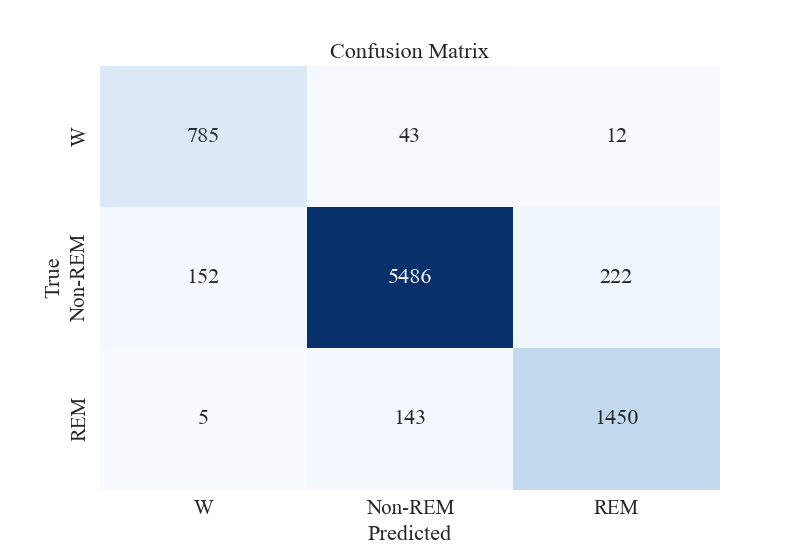

In [81]:
%matplotlib widget
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16
labels = ['W', 'Non-REM', 'REM']
cm = [[ 785,   43,   12],
 [ 152, 5486,  222],
 [   5,  143, 1450]]

plt.figsize=(8,8)
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [64]:
et_3 = create_model('et', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9102,0.9759,0.9073,0.9161,0.9117,0.8107,0.8126
1,0.9122,0.9770,0.9125,0.9167,0.9133,0.8141,0.8156
2,0.9205,0.9804,0.9231,0.9259,0.9217,0.8314,0.8331
3,0.9168,0.9796,0.9153,0.9211,0.9180,0.8239,0.8254
4,0.9148,0.9780,0.9174,0.9224,0.9165,0.8204,0.8227
5,0.9112,0.9752,0.9030,0.9153,0.9119,0.8095,0.8106
6,0.9215,0.9802,0.9239,0.9268,0.9227,0.8338,0.8356
7,0.9122,0.9776,0.9173,0.9187,0.9135,0.8147,0.8167
8,0.9148,0.9788,0.9146,0.9213,0.9162,0.8194,0.8212


In [65]:
rf_3 = create_model('rf', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9241,0.9780,0.9257,0.9298,0.9256,0.8401,0.8422
1,0.9205,0.9787,0.9191,0.9245,0.9215,0.8312,0.8325
2,0.9267,0.9827,0.9241,0.9311,0.9277,0.8436,0.8448
3,0.9251,0.9824,0.9234,0.9290,0.9261,0.8411,0.8425
4,0.9246,0.9814,0.9302,0.9322,0.9264,0.8415,0.8439
5,0.9189,0.9782,0.9102,0.9221,0.9195,0.8255,0.8262
6,0.9339,0.9835,0.9350,0.9385,0.9350,0.8595,0.8609
7,0.9256,0.9801,0.9294,0.9313,0.9269,0.8426,0.8444
8,0.9199,0.9809,0.9187,0.9253,0.9213,0.8303,0.8319


In [66]:
lgbm_3 = create_model('lightgbm', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9293,0.9834,0.9258,0.9331,0.9303,0.8502,0.8518
1,0.9277,0.9840,0.9335,0.9321,0.9288,0.8476,0.8496
2,0.9437,0.9888,0.9446,0.9466,0.9444,0.8801,0.8813
3,0.9334,0.9861,0.9373,0.9379,0.9344,0.8596,0.8618
4,0.9308,0.9863,0.9388,0.9367,0.9322,0.8547,0.8570
5,0.9241,0.9842,0.9169,0.9274,0.9250,0.8384,0.8395
6,0.9447,0.9885,0.9394,0.9463,0.9452,0.8810,0.8815
7,0.9282,0.9859,0.9327,0.9325,0.9292,0.8482,0.8499
8,0.9334,0.9865,0.9281,0.9360,0.9341,0.8577,0.8586


## 2 Stages - REM and NREM

In [82]:
df_input = pd.concat([df_X_svd, df_X_hfd, df_X_perm, df_X_det, df_X_PSD, df_X_time, df_Y ], axis=1)

In [83]:
df_input_2 = df_input[df_input['Sleep Stage'] != 0]
df_input_2['Sleep Stage'].value_counts()

1    29193
2     8149
Name: Sleep Stage, dtype: int64

In [84]:
df_input_2['Sleep Stage'] = df_input_2['Sleep Stage'].apply(lambda x: 0 if x == 1 else 1)

In [85]:
df_input_2 = df_input_2.fillna(0)
df_input_2['Sleep Stage'].value_counts()

0    29193
1     8149
Name: Sleep Stage, dtype: int64

In [86]:
X_train, X_test, y_train, y_test = train_test_split(df_input_2.drop('Sleep Stage', axis=1), df_input_2['Sleep Stage'], test_size=0.2, random_state=123, shuffle=True)
df_input_train = pd.concat([X_train, y_train], axis=1)
df_input_train['Sleep Stage'].value_counts()

0    23342
1     6531
Name: Sleep Stage, dtype: int64

In [87]:
clf = setup(
    data = df_input_train,
    target = 'Sleep Stage',
    normalize = True,
    fix_imbalance=True
    )

,Description,Value
0,session_id,7525
1,Target,Sleep Stage
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(29873, 235)"
5,Missing Values,False
6,Numeric Features,234
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models(fold=15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8744,0.9793,0.8547,0.8777,0.8755,0.8234,0.8238,177.7513
lightgbm,Light Gradient Boosting Machine,0.8714,0.9791,0.8561,0.8764,0.8730,0.8198,0.8204,12.3633
rf,Random Forest Classifier,0.8614,0.9743,0.8396,0.8661,0.8630,0.8051,0.8055,15.4633
et,Extra Trees Classifier,0.8600,0.9732,0.8329,0.8612,0.8601,0.8021,0.8023,9.6213
gbc,Gradient Boosting Classifier,0.8417,0.9717,0.8405,0.8553,0.8454,0.7810,0.7833,223.0213
svm,SVM - Linear Kernel,0.7922,0.0000,0.7954,0.8166,0.7979,0.7159,0.7207,5.8793
knn,K Neighbors Classifier,0.7860,0.9295,0.7940,0.8227,0.7940,0.7109,0.7187,18.8880
lda,Linear Discriminant Analysis,0.7688,0.9387,0.7622,0.7957,0.7771,0.6826,0.6863,6.2940
dt,Decision Tree Classifier,0.7642,0.8410,0.7402,0.7770,0.7688,0.6722,0.6736,8.5440
ridge,Ridge Classifier,0.7401,0.0000,0.7493,0.7739,0.7459,0.6492,0.6572,5.0680


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=7075, reg_alpha=0, ...)

In [88]:
xgb_4 = create_model('xgboost', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9548,0.9889,0.9309,0.8708,0.8998,0.8707,0.8715
1,0.9462,0.9805,0.8911,0.8654,0.8780,0.8435,0.8437
2,0.9591,0.9897,0.9043,0.9073,0.9058,0.8797,0.8797
3,0.9562,0.9898,0.9208,0.8829,0.9015,0.8733,0.8737
4,0.9534,0.9906,0.9175,0.8742,0.8953,0.8654,0.8658
5,0.9598,0.9928,0.9340,0.8871,0.9100,0.8841,0.8846
6,0.9484,0.9850,0.8944,0.8714,0.8827,0.8496,0.8497
7,0.9527,0.9841,0.9142,0.8738,0.8935,0.8631,0.8635
8,0.9491,0.9888,0.8845,0.8816,0.8830,0.8505,0.8505


In [89]:
predictions = predict_model(xgb_4, data=X_test)

In [90]:
predictions

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Label,Score
26215,0.609330,0.535513,0.199016,0.613017,1.543333,1.490271,1.665186,2.007836,0.850043,0.853655,...,-0.968165,0.241185,-0.989588,-0.223752,5.741584,3.122050,-0.098785,0.101742,0,0.9996
19847,0.726310,0.664810,0.165845,0.474855,1.622498,1.583917,1.650308,1.922108,0.892529,0.875960,...,-0.167125,0.279609,-0.423089,-1.166594,0.703350,0.700226,-0.303410,2.001500,1,0.9815
21557,0.566976,0.592585,0.511101,0.989802,1.530842,1.527829,1.653779,2.029967,0.873359,0.882458,...,-0.498472,-0.557512,0.158496,-0.045450,1.658359,0.736491,-0.323872,-0.085384,0,1.0000
6212,0.620740,0.678015,0.147676,0.977923,1.644626,1.559244,1.512012,2.051338,0.856762,0.856578,...,-2.258485,-0.207980,-0.040422,0.011617,15.198658,0.136523,-0.421796,0.084192,0,1.0000
6558,0.636107,0.709586,0.168033,0.422489,1.461242,1.580382,1.501409,1.950924,0.888498,0.878700,...,-0.214848,0.136158,-1.546405,-0.538752,0.007750,0.190227,1.956516,-0.780852,1,0.9987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31023,0.468820,0.458824,0.227196,0.999277,1.379630,1.331740,1.569829,2.031668,0.858261,0.839607,...,0.513772,0.221000,0.776196,0.109845,0.787335,0.656507,-0.160909,1.187583,0,1.0000
20937,0.559558,0.522243,0.477617,0.831814,1.552043,1.528455,1.616709,2.000757,0.860489,0.844436,...,0.981880,-3.030457,0.217681,0.601369,6.164953,20.452526,0.147822,0.831391,0,0.9990
30918,0.256820,0.473301,0.149410,0.791812,1.444202,1.510454,1.399066,1.836804,0.956044,0.922163,...,-2.481141,0.092930,0.508164,-1.656674,10.919374,4.822590,-0.913278,1.975212,1,0.9654
18907,0.524721,0.581473,0.772966,0.590102,1.436988,1.461920,1.728875,1.916311,0.890381,0.877897,...,-0.595831,-0.682425,0.319959,0.627881,3.552004,3.361194,2.084491,-0.112885,0,0.9960


In [91]:
preds = predictions['Label'].astype(float)
accuracy_score(y_test, preds)

0.9550140581068416

In [92]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[5655  196]
 [ 140 1478]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5851
           1       0.88      0.91      0.90      1618

    accuracy                           0.96      7469
   macro avg       0.93      0.94      0.93      7469
weighted avg       0.96      0.96      0.96      7469



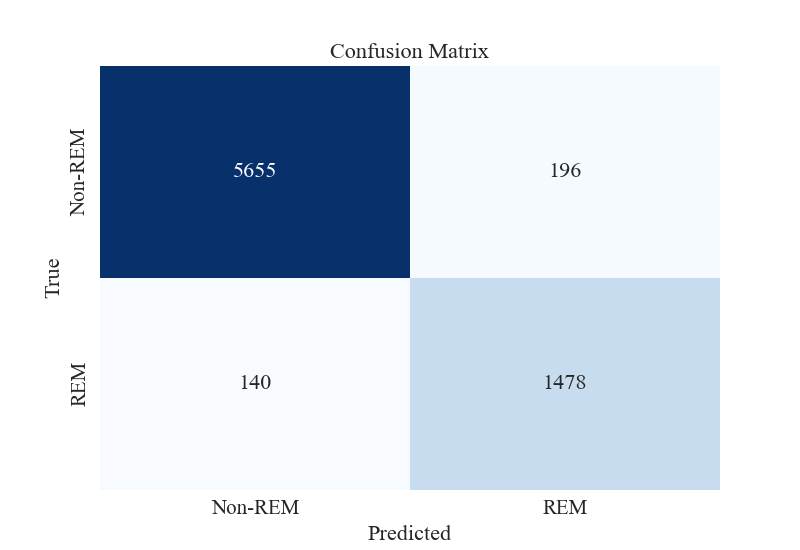

In [93]:
%matplotlib widget
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16
labels = ['Non-REM', 'REM']
cm = [[5655,  196],
 [ 140, 1478]]

plt.figsize=(8,8)
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [77]:
et_4 = create_model('et', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9530,0.9858,0.8987,0.8895,0.8941,0.8638,0.8638
1,0.9472,0.9825,0.8753,0.8845,0.8799,0.8461,0.8461
2,0.9421,0.9795,0.8416,0.8901,0.8652,0.8283,0.8288
3,0.9472,0.9878,0.8779,0.8825,0.8802,0.8464,0.8464
4,0.9512,0.9817,0.8494,0.9237,0.8850,0.8541,0.8553
5,0.9392,0.9784,0.8442,0.8760,0.8598,0.8210,0.8212
6,0.9432,0.9814,0.8701,0.8724,0.8713,0.8348,0.8348
7,0.9421,0.9821,0.8571,0.8777,0.8673,0.8302,0.8303
8,0.9495,0.9852,0.8779,0.8918,0.8848,0.8525,0.8525


In [78]:
lgbm_4 = create_model('lightgbm', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9535,0.9912,0.9299,0.8689,0.8984,0.8683,0.8691
1,0.9478,0.9887,0.9143,0.8585,0.8855,0.8518,0.8525
2,0.9530,0.9853,0.8883,0.8976,0.8930,0.8628,0.8628
3,0.9604,0.9912,0.9532,0.8780,0.9141,0.8884,0.8897
4,0.9558,0.9893,0.9143,0.8889,0.9014,0.8729,0.8731
5,0.9552,0.9837,0.9273,0.8771,0.9015,0.8726,0.8732
6,0.9501,0.9860,0.9247,0.8599,0.8911,0.8588,0.8597
7,0.9587,0.9876,0.9403,0.8808,0.9095,0.8828,0.8836
8,0.9575,0.9914,0.9351,0.8802,0.9068,0.8793,0.8800


In [79]:
rf_4 = create_model('rf', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9610,0.9895,0.9195,0.9054,0.9124,0.8873,0.8873
1,0.9507,0.9855,0.8987,0.8804,0.8895,0.8577,0.8578
2,0.9478,0.9828,0.8571,0.9016,0.8788,0.8456,0.8460
3,0.9558,0.9894,0.9091,0.8929,0.9009,0.8725,0.8725
4,0.9524,0.9866,0.8753,0.9059,0.8904,0.8600,0.8602
5,0.9489,0.9836,0.8649,0.9000,0.8821,0.8495,0.8498
6,0.9495,0.9850,0.8831,0.8877,0.8854,0.8530,0.8530
7,0.9558,0.9862,0.8935,0.9053,0.8993,0.8710,0.8711
8,0.9552,0.9893,0.9039,0.8946,0.8992,0.8705,0.8705


## Awake v/s Asleep Detection

In [98]:
df_input_3 = df_input.copy()
df_input_3['Sleep Stage'].value_counts()

1    29193
2     8149
0     4148
Name: Sleep Stage, dtype: int64

In [99]:
df_input_3['Sleep Stage'] = df_input_3['Sleep Stage'].apply(lambda x: 0 if x == 0 else 1)

In [100]:
df_input_3['Sleep Stage'].value_counts()

1    37342
0     4148
Name: Sleep Stage, dtype: int64

In [101]:
X_train, X_test, y_train, y_test = train_test_split(df_input_3.drop('Sleep Stage', axis=1), df_input_3['Sleep Stage'], test_size=0.2, random_state=123, shuffle=True)
df_input_train = pd.concat([X_train, y_train], axis=1)
df_input_train['Sleep Stage'].value_counts()

1    29884
0     3308
Name: Sleep Stage, dtype: int64

In [102]:
clf = setup(
    data = df_input_train,
    target = 'Sleep Stage',
    normalize = True,
    fix_imbalance=True
    )

,Description,Value
0,session_id,7941
1,Target,Sleep Stage
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(33192, 235)"
5,Missing Values,True
6,Numeric Features,234
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models(fold=15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8744,0.9793,0.8547,0.8777,0.8755,0.8234,0.8238,177.7513
lightgbm,Light Gradient Boosting Machine,0.8714,0.9791,0.8561,0.8764,0.8730,0.8198,0.8204,12.3633
rf,Random Forest Classifier,0.8614,0.9743,0.8396,0.8661,0.8630,0.8051,0.8055,15.4633
et,Extra Trees Classifier,0.8600,0.9732,0.8329,0.8612,0.8601,0.8021,0.8023,9.6213
gbc,Gradient Boosting Classifier,0.8417,0.9717,0.8405,0.8553,0.8454,0.7810,0.7833,223.0213
svm,SVM - Linear Kernel,0.7922,0.0000,0.7954,0.8166,0.7979,0.7159,0.7207,5.8793
knn,K Neighbors Classifier,0.7860,0.9295,0.7940,0.8227,0.7940,0.7109,0.7187,18.8880
lda,Linear Discriminant Analysis,0.7688,0.9387,0.7622,0.7957,0.7771,0.6826,0.6863,6.2940
dt,Decision Tree Classifier,0.7642,0.8410,0.7402,0.7770,0.7688,0.6722,0.6736,8.5440
ridge,Ridge Classifier,0.7401,0.0000,0.7493,0.7739,0.7459,0.6492,0.6572,5.0680


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=7075, reg_alpha=0, ...)

In [103]:
xgb_4 = create_model('xgboost', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9774,0.9963,0.9799,0.9949,0.9874,0.8817,0.8839
1,0.9742,0.9962,0.9763,0.9949,0.9855,0.8666,0.8698
2,0.9684,0.9955,0.9727,0.9920,0.9823,0.8370,0.8404
3,0.9690,0.9925,0.9770,0.9884,0.9827,0.8355,0.8368
4,0.9826,0.9975,0.9835,0.9971,0.9902,0.9082,0.9101
5,0.9729,0.9952,0.9749,0.9949,0.9848,0.8606,0.8644
6,0.9755,0.9942,0.9813,0.9913,0.9863,0.8690,0.8701
7,0.9755,0.9959,0.9778,0.9949,0.9863,0.8726,0.8754
8,0.9677,0.9931,0.9735,0.9905,0.9819,0.8323,0.8350


In [104]:
predictions = predict_model(xgb_4, data=X_test)

In [105]:
predictions

,EEG Fpz-Cz_svd,EEG Pz-Oz_svd,EOG horizontal_svd,EMG submental_svd,EEG Fpz-Cz_hfd,EEG Pz-Oz_hfd,EOG horizontal_hfd,EMG submental_hfd,EEG Fpz-Cz_perm,EEG Pz-Oz_perm,...,EEG Fpz-Cz_skew,EEG Pz-Oz_skew,EOG horizontal_skew,EMG submental_skew,EEG Fpz-Cz_kurt,EEG Pz-Oz_kurt,EOG horizontal_kurt,EMG submental_kurt,Label,Score
18567,0.522136,0.555490,0.748603,0.629966,1.379251,1.412683,1.647078,1.899378,0.817266,0.828515,...,-0.389810,-0.126041,0.277877,-0.520437,0.631381,0.460520,0.371023,-0.027936,1,1.0000
19479,0.687469,0.704091,0.148299,0.701872,1.555299,1.557796,1.533088,2.011091,0.926247,0.910469,...,0.153854,-0.219804,0.755771,-0.014284,1.284759,1.337007,0.317921,-0.142993,1,0.9971
13747,0.628773,0.723419,0.151898,0.711818,1.593170,1.563852,1.438214,1.956108,0.930798,0.933330,...,-0.126422,-0.356987,0.437253,-0.041045,0.126070,0.834838,0.044838,-0.244604,1,1.0000
29625,0.607749,0.637054,0.624866,0.653667,1.461953,1.515899,1.581997,1.913407,0.883679,0.900937,...,0.307589,-0.120329,0.565389,-0.327653,0.960171,0.549358,0.735457,0.188843,1,1.0000
10651,0.497123,0.507046,0.539025,0.364005,1.486402,1.477578,1.577149,1.546574,0.881483,0.871074,...,1.280386,-0.270902,-0.124251,-0.437685,3.919170,3.029200,-0.023671,-1.177968,1,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25274,0.443077,0.444879,0.180270,0.492666,1.373709,1.365362,1.383294,1.954051,0.806453,0.824010,...,-0.475137,-0.358130,0.467285,-0.885676,0.706803,0.801726,-0.478614,1.357755,1,1.0000
2030,0.523434,0.837868,0.423255,0.952573,1.678808,1.825048,1.709062,2.028145,0.968637,0.952494,...,1.399590,-0.095574,-0.848940,0.129568,4.928953,0.283397,3.930070,-0.338373,0,0.9999
18532,0.614656,0.624886,0.713591,0.725425,1.455713,1.457120,1.638692,1.889728,0.852662,0.862434,...,-0.091391,-0.119084,0.120504,0.267245,0.182867,0.463823,0.164600,-0.343341,1,1.0000
3197,0.326508,0.338753,0.323336,0.791442,1.194303,1.229151,1.273737,1.930606,0.768572,0.801872,...,-0.228971,-0.136023,0.497156,0.186423,0.063182,0.257340,0.390595,-0.589227,1,1.0000


In [106]:
preds = predictions['Label'].astype(float)
accuracy_score(y_test, preds)

0.9746926970354303

In [107]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[ 784   56]
 [ 154 7304]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       840
           1       0.99      0.98      0.99      7458

    accuracy                           0.97      8298
   macro avg       0.91      0.96      0.93      8298
weighted avg       0.98      0.97      0.98      8298



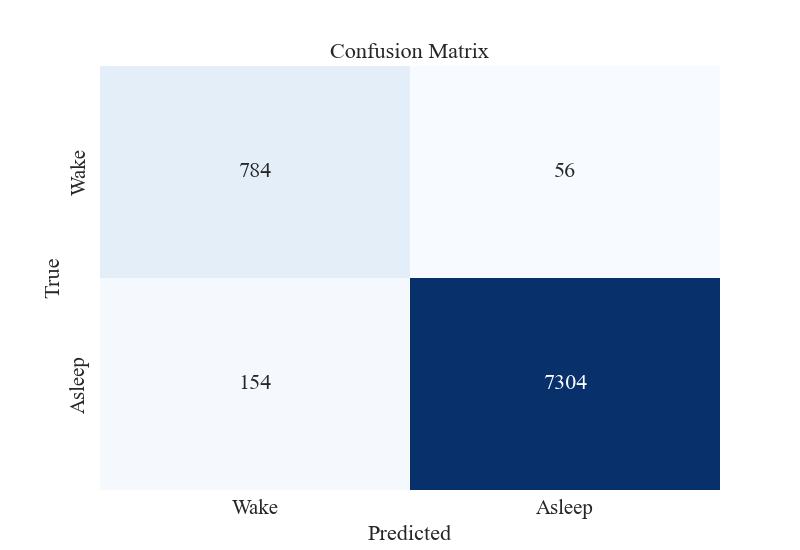

In [111]:
%matplotlib widget
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16
labels = ['Wake', 'Asleep']
cm = [[ 784,   56],
 [ 154, 7304]]

plt.figsize=(8,8)
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [108]:
et_5 = create_model('et', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9709,0.9957,0.9720,0.9956,0.9837,0.8526,0.8577
1,0.9697,0.9958,0.9699,0.9963,0.9829,0.8477,0.8538
2,0.9613,0.9918,0.9656,0.9912,0.9782,0.8051,0.8106
3,0.9626,0.9910,0.9684,0.9897,0.9790,0.8086,0.8126
4,0.9768,0.9977,0.9756,0.9985,0.9869,0.8818,0.8867
5,0.9703,0.9952,0.9706,0.9963,0.9833,0.8505,0.8564
6,0.9716,0.9939,0.9735,0.9949,0.9840,0.8548,0.8590
7,0.9709,0.9938,0.9727,0.9949,0.9837,0.8519,0.8563
8,0.9600,0.9909,0.9634,0.9919,0.9774,0.8006,0.8073


In [109]:
lgbm_5 = create_model('lightgbm', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9729,0.9957,0.9742,0.9956,0.9848,0.8614,0.8656
1,0.9748,0.9958,0.9770,0.9949,0.9859,0.8696,0.8726
2,0.9677,0.9951,0.9727,0.9912,0.9819,0.8332,0.8364
3,0.9684,0.9924,0.9749,0.9898,0.9823,0.8343,0.8364
4,0.9806,0.9976,0.9821,0.9964,0.9892,0.8983,0.9004
5,0.9684,0.9959,0.9692,0.9956,0.9822,0.8412,0.8473
6,0.9729,0.9933,0.9785,0.9913,0.9848,0.8568,0.8585
7,0.9690,0.9948,0.9699,0.9956,0.9826,0.8440,0.8499
8,0.9690,0.9936,0.9742,0.9912,0.9826,0.8390,0.8418


In [110]:
rf_5 = create_model('rf', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9664,0.9946,0.9684,0.9941,0.9811,0.8310,0.8368
1,0.9709,0.9941,0.9720,0.9956,0.9837,0.8526,0.8577
2,0.9626,0.9903,0.9648,0.9934,0.9789,0.8135,0.8203
3,0.9613,0.9902,0.9684,0.9883,0.9783,0.8009,0.8044
4,0.9781,0.9965,0.9785,0.9971,0.9877,0.8866,0.8899
5,0.9677,0.9943,0.9692,0.9948,0.9818,0.8375,0.8433
6,0.9709,0.9925,0.9735,0.9941,0.9837,0.8511,0.8550
7,0.9690,0.9940,0.9692,0.9963,0.9825,0.8448,0.8513
8,0.9593,0.9914,0.9641,0.9904,0.9771,0.7958,0.8016
